# GP Initial Implementation: pyro

In [1]:
# Import needed libraries and modules
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
import torch
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
import pyro
import pyro.contrib.gp as gp

# Fetch dataset from UCI Repository
from ucimlrepo import fetch_ucirepo
heart_disease = fetch_ucirepo(id=45)
df = heart_disease.data.original

In [2]:
# ---------------------------------------------------------------------------- #
#                                PRE-PROCESSING                                #
# ---------------------------------------------------------------------------- #

# --------------------------------- SETTINGS --------------------------------- #
Normalize = False
PC_Features = True
Test_Size = 0.2
Random_Seed = 82024
Torch = True

# Drop missing values
df = df.dropna()
df = df.reset_index(drop=True)

# Binarize target
df.loc[df['num'] != 0, 'num'] = 1

# Define features and target vectors
X = df.iloc[:,:-1]
y = df['num']

# Normalize if requested
if (Normalize) or (PC_Features):
    int_features, cat_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak'],\
    ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
    
    preprocessor = ColumnTransformer(
    transformers=[
        ('int', StandardScaler(), int_features),
        ('cat', OneHotEncoder(), cat_features)
    ])
    X = preprocessor.fit_transform(X)
else:
    X = X.values

# Apply PCA if requested
if PC_Features:
    pca = PCA(n_components=12)
    X = pca.fit_transform(X)

# Split train and test data
index = list(range(y.size))
train_index, test_index = train_test_split(index, test_size=Test_Size, random_state=Random_Seed)

train_X = X[train_index]
train_y = y.loc[train_index].values

test_X = X[test_index]
test_y = y.loc[test_index].values

# Convert to torch tensor if requested
if Torch:
    train_X, train_y, test_X, test_y = torch.tensor(train_X),\
    torch.tensor(train_y).double(), torch.tensor(test_X), torch.tensor(test_y).double()

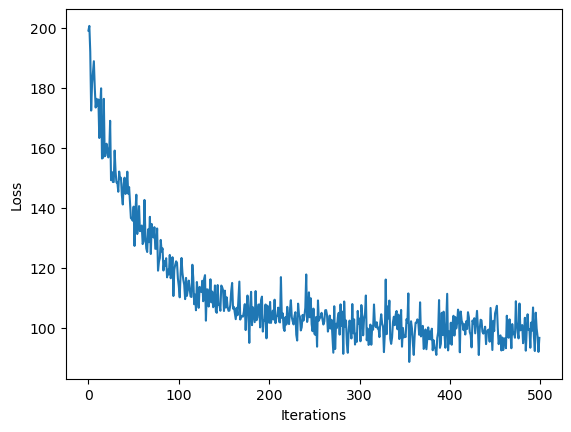

Accuracy: 0.67
ROC AUC: 0.66


In [3]:
# ---------------------------------------------------------------------------- #
#                                     MODEL                                    #
# ---------------------------------------------------------------------------- #

# Create model
kernel = gp.kernels.RBF(input_dim=X.shape[1])
pyro.clear_param_store()
likelihood = gp.likelihoods.Binary()
model = gp.models.VariationalGP(
    train_X,
    train_y,
    kernel,
    likelihood=likelihood,
    whiten=True,
    jitter=1e-03
)

# Train model
num_steps = 500
loss = gp.util.train(model, num_steps=num_steps)

# Plot loss values
plt.plot(loss)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

# Test model
mean, var = model(test_X)
y_pred = model.likelihood(mean, var)
pred_preobs = y_pred.detach().numpy()

# Evaluation
acc = accuracy_score(test_y, y_pred)
roc_auc = roc_auc_score(test_y.numpy(), pred_preobs)

print(f"Accuracy: {acc:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")